# Imports & Functions

In [138]:
import requests
import json
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def fetch_data(url, headers):
    response = requests.get(url, headers=headers)
    return response.json() if response.status_code == 200 else None

In [23]:
def encode_url(base_url, params):
    query_string = urlencode(params)
    return f"{base_url}?{query_string}"

In [24]:
def fetch_data_post(url, headers, data):
    response = requests.post(url, headers=headers, json=data, verify=False)
    return response.json() if response.status_code == 200 else None

# GW Level Station Locations

In [40]:
url = 'https://arc.indiawris.gov.in/server/rest/services/NWIC/GroundwaterLevel_Stations/MapServer/0/query'

In [41]:
payload = {
    "where": "agency_name='CGWB'AND state_code ='AS'",
    # "geometry": '{"spatialReference":{"latestWkid":3857,"wkid":102100},"xmin":10057889.929871026,"ymin":3052589.161598988,"xmax":10097025.688353024,"ymax":3091724.920080986}',
    # "geometryType": "esriGeometryEnvelope",
    # "spatialRel": "esriSpatialRelIntersects",
    # "units": "esriSRUnit_Foot",
    # "inSR": 102100,
    "outFields": "*",
    "returnGeometry": True,
    "returnTrueCurves": False,
    "outSR": 4326,
    "returnIdsOnly": False,
    "returnCountOnly": False,
    "orderByFields": "objectid ASC",
    "returnZ": False,
    "returnM": False,
    "returnDistinctValues": False,
    # "quantizationParameters": '{"extent":{"spatialReference":{"latestWkid":3857,"wkid":102100},"xmin":10057889.929871026,"ymin":3052589.161598988,"xmax":10097025.688353024,"ymax":3091724.920080986},"mode":"view","originPosition":"upperLeft","tolerance":76.43702828515632}',
    "featureEncoding": "esriDefault",
    "f": "geojson"
}

In [42]:
encoded_url = encode_url(url, payload)

In [43]:
response = fetch_data(encoded_url, headers={'Content-Type': 'application/json'})
print(json.dumps(response, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "id": 393418,
      "geometry": {
        "type": "Point",
        "coordinates": [
          92.54999999996151,
          24.369999999979818
        ]
      },
      "properties": {
        "objectid": 393418,
        "station_id": null,
        "station_code": "CGWB1ASHLD006",
        "station_name": "Alaicherra-V",
        "station_type": "Ground Water",
        "lat": 24.37,
        "long": 92.55,
        "telemetry": 1,
        "agency_name": "CGWB",
        "agency_id": 113,
        "state_name": "Assam",
        "state_code": "AS",
        "district_name": "Hailakandi",
        "district_code": null,
        "block_name": "-",
        "block_code": null,
        "basin_name": "Barak and Others Basin",
        "basin_code": null,
        "sub_basin_name": "Barak",
        "sub_basin_code": null,
        "created_date": 1682985600000,
        "remarks": null,
        "remarks1": null,
        "re

# GW Level Data Download

In [41]:
url = 'https://indiawris.gov.in/gwldnlddata'

In [42]:
payload = {"stnVal":{
    "Agency_name":"CGWB",
    "Child":"All",
    # "Name": "Balakumaran",
    # "Email": "balakumaran.ramachandran@ifmr.ac.in",
    "Startdate": "2023-01-01",
    "Enddate": "2023-12-31",
    "Parent": "\"'Assam'\"",
    "Reporttype": "GWL data",
    "Station": "All",
    "Timestep": "Daily",
    "View": "Admin",
    "file_name": "Sample"#"Balakumaran"
}}

In [44]:
response = fetch_data_post(url, headers={'Content-Type': 'application/json'}, data=payload)
print(json.dumps(response, indent=2))

c:\Users\atree\miniconda3\envs\jaltol\lib\site-packages\urllib3\connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'indiawris.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


[
  {
    "District": "Bongaigaon",
    "Telemetry": 2,
    "Agency_name": "CGWB",
    "State": "Assam",
    "Station_name": "Abhayapuri",
    "Data": [
      {
        "Date": "2023-01-31",
        "level": 4.1
      },
      {
        "Date": "2023-03-31",
        "level": 0.0
      },
      {
        "Date": "2023-08-31",
        "level": 2.0
      }
    ]
  },
  {
    "District": "Goalpara",
    "Telemetry": 2,
    "Agency_name": "CGWB",
    "State": "Assam",
    "Station_name": "Agia",
    "Data": [
      {
        "Date": "2023-01-31",
        "level": 2.15
      },
      {
        "Date": "2023-03-31",
        "level": 2.84
      }
    ]
  },
  {
    "District": "Hailakandi",
    "Telemetry": 1,
    "Agency_name": "CGWB",
    "State": "Assam",
    "Station_name": "Alaicherra-V",
    "Data": [
      {
        "Date": "2023-01-31",
        "level": 8.15
      },
      {
        "Date": "2023-06-08",
        "level": 10.62
      },
      {
        "Date": "2023-06-09",
        "lev

In [45]:
print(response[0].keys())

dict_keys(['District', 'Telemetry', 'Agency_name', 'State', 'Station_name', 'Data'])


# Groundwater Level Map

In [83]:
url = 'https://arc.indiawris.gov.in/server/rest/services/del/Ground_Water_Level/GPServer/Ground%20Water%20Level/submitJob?'

In [84]:
payload = 'query=Startdate = 2023-05 AND Enddate = 2024-05 AND Timestep = Monthly AND Agency_name = null&f=json'

In [85]:
encoded_url = url+payload
print(encoded_url)

https://arc.indiawris.gov.in/server/rest/services/del/Ground_Water_Level/GPServer/Ground%20Water%20Level/submitJob?query=Startdate = 2023-05 AND Enddate = 2024-05 AND Timestep = Monthly AND Agency_name = null&f=json


In [86]:
response = fetch_data(encoded_url, headers={'Content-Type': 'application/json'})
print(json.dumps(response, indent=2))

{
  "jobId": "j7cc0a2f101f64b7ab1b7c2dab3b6621d",
  "jobStatus": "esriJobSubmitted"
}


In [87]:
jobid = response['jobId']

In [91]:
fail_url = f'https://arc.indiawris.gov.in/server/rest/services/del/Ground_Water_Level/GPServer/Ground%20Water%20Level/jobs/{jobid}/results/Depth_To_Water_Level_m_bgl_'
print(fail_url)

https://arc.indiawris.gov.in/server/rest/services/del/Ground_Water_Level/GPServer/Ground%20Water%20Level/jobs/j7cc0a2f101f64b7ab1b7c2dab3b6621d/results/Depth_To_Water_Level_m_bgl_


In [92]:
fail_response = fetch_data(fail_url, headers={'Content-Type': 'application/json'})
print(fail_response)
# print(json.dumps(fail_response, indent=2))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [79]:
result_url = f'https://arc.indiawris.gov.in/server/rest/services/del/Ground_Water_Level/MapServer/jobs/{jobid}?f=json'

In [80]:
response = fetch_data(result_url, headers={'Content-Type': 'application/json'})
print(json.dumps(response, indent=2))

{
  "currentVersion": 10.81,
  "serviceDescription": "",
  "mapName": "jdcc401483cbe4ff6b86b2514ed2aa626",
  "description": "",
  "copyrightText": "",
  "supportsDynamicLayers": true,
  "layers": [
    {
      "id": 0,
      "name": "Depth To Water Level(m bgl)",
      "parentLayerId": -1,
      "defaultVisibility": true,
      "subLayerIds": null,
      "minScale": 0,
      "maxScale": 0,
      "type": "Raster Layer"
    }
  ],
  "tables": [],
  "spatialReference": {
    "wkid": 4326,
    "latestWkid": 4326
  },
  "singleFusedMapCache": false,
  "initialExtent": {
    "xmin": 66.72479680925005,
    "ymin": 6.5554798298935015,
    "xmax": 98.87674485175006,
    "ymax": 38.53173416724324,
    "spatialReference": {
      "wkid": 4326,
      "latestWkid": 4326
    }
  },
  "fullExtent": {
    "xmin": 68.18624899300005,
    "ymin": 8.077847034000058,
    "xmax": 97.41529266800006,
    "ymax": 37.078268061000074,
    "spatialReference": {
      "wkid": 4326,
      "latestWkid": 4326
    }
 

In [81]:
legend_url = f'https://arc.indiawris.gov.in/server/rest/services/del/Ground_Water_Level/MapServer/jobs/{jobid}/legend?f=json'

In [82]:
response = fetch_data(legend_url, headers={'Content-Type': 'application/json'})
print(json.dumps(response, indent=2))

{
  "layers": [
    {
      "layerId": 0,
      "layerName": "Depth To Water Level(m bgl)",
      "layerType": "Raster Layer",
      "minScale": 0,
      "maxScale": 0,
      "legend": [
        {
          "label": "<2",
          "url": "6b4e3f3d76b5fe5e218263a0ae15d0f7",
          "imageData": "iVBORw0KGgoAAAANSUhEUgAAABQAAAAUCAYAAACNiR0NAAAAAXNSR0IB2cksfwAAAAlwSFlzAAAOxAAADsQBlSsOGwAAADtJREFUOI1jYaAyYKGlgf+pYB4jiguFJMk3891zRgYGBhp7edTAUQNHDRw1ELuBsCKITMCIbiBFpsEAAFNJBimgIA1dAAAAAElFTkSuQmCC",
          "contentType": "image/png",
          "height": 20,
          "width": 20
        },
        {
          "label": "2 - 5",
          "url": "e4f4c90ba6c4e8b209e3c89fe101aa93",
          "imageData": "iVBORw0KGgoAAAANSUhEUgAAABQAAAAUCAYAAACNiR0NAAAAAXNSR0IB2cksfwAAAAlwSFlzAAAOxAAADsQBlSsOGwAAADtJREFUOI1jYaAyYKGlgf+pYB4jqgvL2Mk3qusnAwMDjb08auCogaMGjhqIw0BoEUQmYEQ3kJES02AAAOCBBNZgJLYKAAAAAElFTkSuQmCC",
          "contentType": "image/png",
          "height": 20,
          "width": 20
 

# Jaltol UseCase

#### Code

In [1]:
import ee
ee.Initialize()

In [68]:
shrug = ee.FeatureCollection('users/jaltolwelllabs/SHRUG/Jharkhand')

In [69]:
roi = shrug.filter(ee.Filter.And(
    ee.Filter.eq('district_n', 'saraikela kharsawan'),
    ee.Filter.eq('subdistric', 'gobindpur rajnagar'),
    ee.Filter.eq('village_na', 'namibera')
))

In [70]:
buffer = roi.geometry().buffer(10000)

In [71]:
coordinates = buffer.getInfo()['coordinates'][0]

In [72]:
long, lat = zip(*coordinates)

In [73]:
print(long)
print(lat)

(85.89745817450422, 85.89862016617599, 85.8999302678096, 85.9011037938237, 85.90396082245856, 85.90511692056164, 85.90573236295486, 85.9061907602389, 85.907687197377, 85.90808422401628, 85.90956547229948, 85.9104296699901, 85.91076764607948, 85.91099612952847, 85.91223423617761, 85.9127392529372, 85.91446854783527, 85.9147795886348, 85.91533429488736, 85.9171159815919, 85.91766890015926, 85.92177649268979, 85.92488975712702, 85.9263554436866, 85.92925911801788, 85.92968399374723, 85.93002546811954, 85.93562657439625, 85.9365224657324, 85.9382362257339, 85.93855962246057, 85.93877866997607, 85.93901083325306, 85.9405216479332, 85.9413507765301, 85.94672955671666, 85.94783958461628, 85.9482229517665, 85.95293089544222, 85.95323755171471, 85.95387797673459, 85.95637648509926, 85.9575129521776, 85.9604182152526, 85.96309907034737, 85.96567859640153, 85.96654315926061, 85.97256987158592, 85.97587354151135, 85.97781851319878, 85.9778672209863, 85.97791395544445, 85.97851693153723, 85.9794528

In [74]:
min_long = min(long)
max_long = max(long)
min_lat = min(lat)
max_lat = max(lat)
print(min_long, max_long)
print(min_lat, max_lat)

85.89061599426405 86.09953322965734
22.54299539938464 22.73746447907452


In [75]:
# location of GWL station
url = 'https://arc.indiawris.gov.in/server/rest/services/NWIC/GroundwaterLevel_Stations/MapServer/0/query'

In [76]:
payload = {
    "where": "agency_name='CGWB'",#AND state_code ='AS'",
    "geometry": '{"spatialReference":{"latestWkid":4326,"wkid":4326},"xmin":'+str(min_long)+',"ymin":'+str(min_lat)+',"xmax":'+str(max_long)+',"ymax":'+str(max_lat)+'}',
    "geometryType": "esriGeometryEnvelope",
    "spatialRel": "esriSpatialRelIntersects",
    "units": "esriSRUnit_Foot",
    "inSR": 4326,
    "outFields": "*",
    "returnGeometry": True,
    "returnTrueCurves": False,
    "outSR": 4326,
    "returnIdsOnly": False,
    "returnCountOnly": False,
    "orderByFields": "objectid ASC",
    "returnZ": False,
    "returnM": False,
    "returnDistinctValues": False,
    # "quantizationParameters": '{"extent":{"spatialReference":{"latestWkid":3857,"wkid":102100},"xmin":10057889.929871026,"ymin":3052589.161598988,"xmax":10097025.688353024,"ymax":3091724.920080986},"mode":"view","originPosition":"upperLeft","tolerance":76.43702828515632}',
    "featureEncoding": "esriDefault",
    "f": "geojson"
}

In [77]:
encoded_url = encode_url(url, payload)
response = fetch_data(encoded_url, headers={'Content-Type': 'application/json'})
print(json.dumps(response, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "id": 378652,
      "geometry": {
        "type": "Point",
        "coordinates": [
          85.92500000012274,
          22.58333333016244
        ]
      },
      "properties": {
        "objectid": 378652,
        "station_id": null,
        "station_code": "223500085553001",
        "station_name": "Rajnagar",
        "station_type": "Ground Water",
        "lat": 22.583333330000002,
        "long": 85.925,
        "telemetry": 2,
        "agency_name": "CGWB",
        "agency_id": 113,
        "state_name": "Jharkhand",
        "state_code": "JH",
        "district_name": "Pashchimi Singhbhum",
        "district_code": null,
        "block_name": "GOBINDPUR (RAJNAGAR)",
        "block_code": null,
        "basin_name": "Subernarekha Basin",
        "basin_code": null,
        "sub_basin_name": "Subernarekha",
        "sub_basin_code": null,
        "created_date": 1553212800000,
        "remarks

In [78]:
stations = {feat['properties']['station_name']:(feat['geometry']['coordinates'],feat['properties']['state_name']) for feat in response['features']}
print(stations)

{'Rajnagar': ([85.92500000012274, 22.58333333016244], 'Jharkhand'), 'Nabibera': ([86.00055555953912, 22.644444439711954], 'Jharkhand'), 'Saraikela': ([85.92083333034664, 22.70416666986437], 'Jharkhand')}


In [79]:
roi_centroid = roi.geometry().centroid().getInfo()['coordinates']
print(roi_centroid)

[85.99588167228957, 22.639621727044865]


In [80]:
def distance(coord1, coord2):
    from math import radians, sin, cos, sqrt, atan2
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    R = 6371.0  # Radius of the Earth in kilometers

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [124]:
close_station = None
for station, data in stations.items():
    station_coord = data[0]
    dist = distance(roi_centroid, station_coord)
    if close_station is None or dist < close_station[1]:
        close_station = (station, dist)
print(f"Closest station: {close_station[0]} at distance {close_station[1]} km")

Closest station: Nabibera at distance 0.5210582633704774 km


In [125]:
url = 'https://indiawris.gov.in/gwldnlddata'
def gen_payload(start_date, end_date, close_station):
    payload = {"stnVal":{
        "Agency_name":"CGWB",
        "Child":"All",
        "Startdate": start_date,
        "Enddate": end_date,
        "Parent": f"\"'{close_station}'\"",
        "Reporttype": "GWL data",
        "Station": "All",
        "Timestep": "Daily",
        "View": "Admin",
        "file_name": "Sample"
    }}
    return payload

In [126]:
filtered_dict = {'2022-23':[], '2021-22': [], '2020-21': [], '2019-20': [], '2018-19': [], '2017-18': []}

In [127]:
payload = gen_payload("2022-07-01", "2023-07-01", stations[close_station[0]][1])
response = fetch_data_post(url, headers={'Content-Type': 'application/json'}, data=payload)
for entry in response:
    if entry['Station_name'] == close_station[0]:
        for data in entry['Data']:
            filtered_dict['2022-23'].append(data['level'])

c:\Users\atree\miniconda3\envs\jaltol\lib\site-packages\urllib3\connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'indiawris.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [128]:
payload = gen_payload("2021-07-01", "2022-07-01", stations[close_station[0]][1])
response = fetch_data_post(url, headers={'Content-Type': 'application/json'}, data=payload)
for entry in response:
    if entry['Station_name'] == close_station[0]:
        for data in entry['Data']:
            filtered_dict['2021-22'].append(data['level'])

c:\Users\atree\miniconda3\envs\jaltol\lib\site-packages\urllib3\connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'indiawris.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [129]:
payload = gen_payload("2020-07-01", "2021-07-01", stations[close_station[0]][1])
response = fetch_data_post(url, headers={'Content-Type': 'application/json'}, data=payload)
for entry in response:
    if entry['Station_name'] == close_station[0]:
        for data in entry['Data']:
            filtered_dict['2020-21'].append(data['level'])

c:\Users\atree\miniconda3\envs\jaltol\lib\site-packages\urllib3\connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'indiawris.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [130]:
payload = gen_payload("2019-07-01", "2020-07-01", stations[close_station[0]][1])
response = fetch_data_post(url, headers={'Content-Type': 'application/json'}, data=payload)
for entry in response:
    if entry['Station_name'] == close_station[0]:
        for data in entry['Data']:
            filtered_dict['2019-20'].append(data['level'])

c:\Users\atree\miniconda3\envs\jaltol\lib\site-packages\urllib3\connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'indiawris.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [131]:
payload = gen_payload("2018-07-01", "2019-07-01", stations[close_station[0]][1])
response = fetch_data_post(url, headers={'Content-Type': 'application/json'}, data=payload)
for entry in response:
    if entry['Station_name'] == close_station[0]:
        for data in entry['Data']:
            filtered_dict['2018-19'].append(data['level'])

c:\Users\atree\miniconda3\envs\jaltol\lib\site-packages\urllib3\connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'indiawris.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [132]:
payload = gen_payload("2017-07-01", "2018-07-01", stations[close_station[0]][1])
response = fetch_data_post(url, headers={'Content-Type': 'application/json'}, data=payload)
for entry in response:
    if entry['Station_name'] == close_station[0]:
        for data in entry['Data']:
            filtered_dict['2017-18'].append(data['level'])

c:\Users\atree\miniconda3\envs\jaltol\lib\site-packages\urllib3\connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'indiawris.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [136]:
print(filtered_dict)

{'2022-23': [2.8, 6.1], '2021-22': [], '2020-21': [1.9, 9.9], '2019-20': [], '2018-19': [7.35, 8.0, 6.48], '2017-18': [7.65, 10.35, 10.35]}


In [135]:
final_out = {k:{'min':min(v,default=None), 'max':max(v,default=None)} for k,v in filtered_dict.items()}
print(final_out)

{'2022-23': {'min': 2.8, 'max': 6.1}, '2021-22': {'min': None, 'max': None}, '2020-21': {'min': 1.9, 'max': 9.9}, '2019-20': {'min': None, 'max': None}, '2018-19': {'min': 6.48, 'max': 8.0}, '2017-18': {'min': 7.65, 'max': 10.35}}


In [139]:
def plot_inverted_stacked_chart(final_out):
    # Extract years and values
    years = list(final_out.keys())
    min_values = [final_out[year]['min'] if final_out[year]['min'] is not None else 0 for year in years]
    max_values = [final_out[year]['max'] if final_out[year]['max'] is not None else 0 for year in years]
    
    # Compute the height of the bars (difference between max and min)
    bar_heights = [max_val - min_val if max_val and min_val else 0 for min_val, max_val in zip(min_values, max_values)]
    
    # Reverse data order to start from 2017
    years.reverse()
    min_values.reverse()
    max_values.reverse()
    bar_heights.reverse()

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    x_positions = np.arange(len(years))

    # Plot stacked bars upside-down
    ax.bar(x_positions, bar_heights, bottom=min_values, color='steelblue', label="Range (Max - Min)")
    ax.bar(x_positions, min_values, color='lightgray', label="Min Value")

    # Labels and formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(years, rotation=45, ha='right')
    ax.set_ylabel("Value")
    ax.set_xlabel("Year")
    ax.set_title("Upside-Down Stacked Bar Chart (Starting from 2017)")
    ax.legend()
    ax.invert_yaxis()  # Invert to make bars appear upside down

    # Show plot
    plt.show()

#### Result

Steps:
- we get the village boundary (function already in jaltol)
- Jharkhand -> saraikela kharsawan -> gobindpur rajnagar -> namibera
- Create a Buffer for 10Km
- get the min & max values of both lat & long of the buffer for bbox param in API call
- Call the GWL Stations Location API to get the lat-long of stations inside the bbox of buffer
- Find the station closest to the Village (least distance bw lat-long of village centroid & station)
- Call the GWL Data API for the closest station's state for different hydrological years
- filter the station name in downloaded json with the closest station's name
- grab all the level data values available for each year as dict
- get the min and max level values for each year and plot them

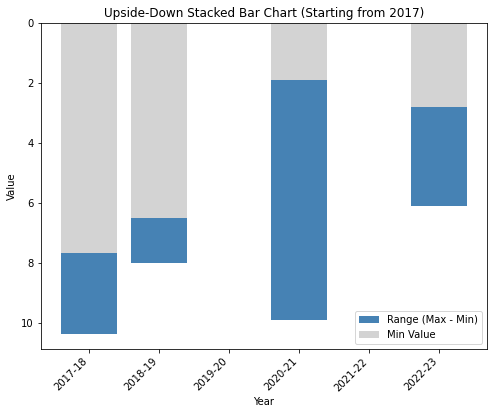

In [140]:
plot_inverted_stacked_chart(final_out)